# Task 3: EDA 

#### The code below will take you through our initial data analysis and how we selected what preprocessing needed to be done before we performed gradient boosted tree regression. 

In [1]:
# Libraries and modules we will need for all 3 Tasks are listed here
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math 
# All sklearn functions below are for part 1 and 3, they are not used in part 2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Initial Data Analysis: Nulls, Distributions, etc

In [2]:
#Upload data in dataframe
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv('housing.csv', sep = '\s+', header = None, names = column_names) 
df.head()

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
C:\Users\EmmaBland\AppData\Local\Temp\ipykernel_2328\1694450544.py:3: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv('housing.csv', sep = '\s+', header = None, names = column_names)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [3]:
# Check data for nulls, correct data types, etc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


### Feature Selection: Correlation Heatmap, Outlier Analysis 

#### Correlation Map:

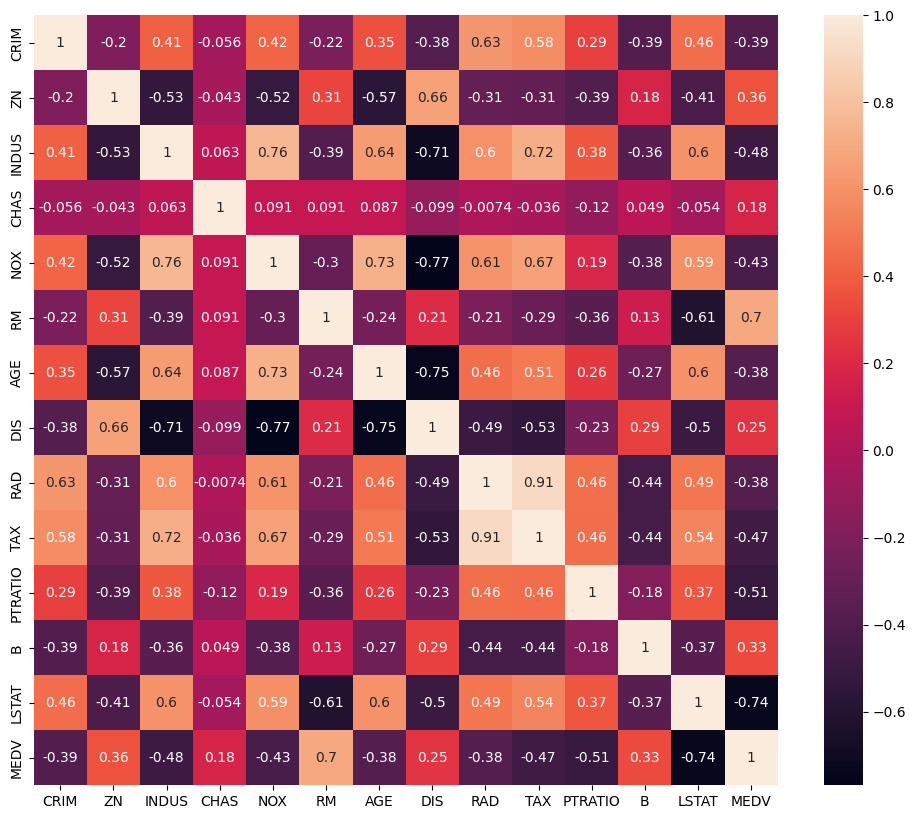

In [4]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize= (12,10))
g = sns.heatmap(df_corr, annot=True, ax=ax)
plt.show()

#### Conclusions: 

##### - MEDV has a strong correlation with...
##### - But we can see that *list features here* are strongly correlated, so we only need to use one
##### - Any other things we get from this figure

### Outliers Analysis: 

#### Identification

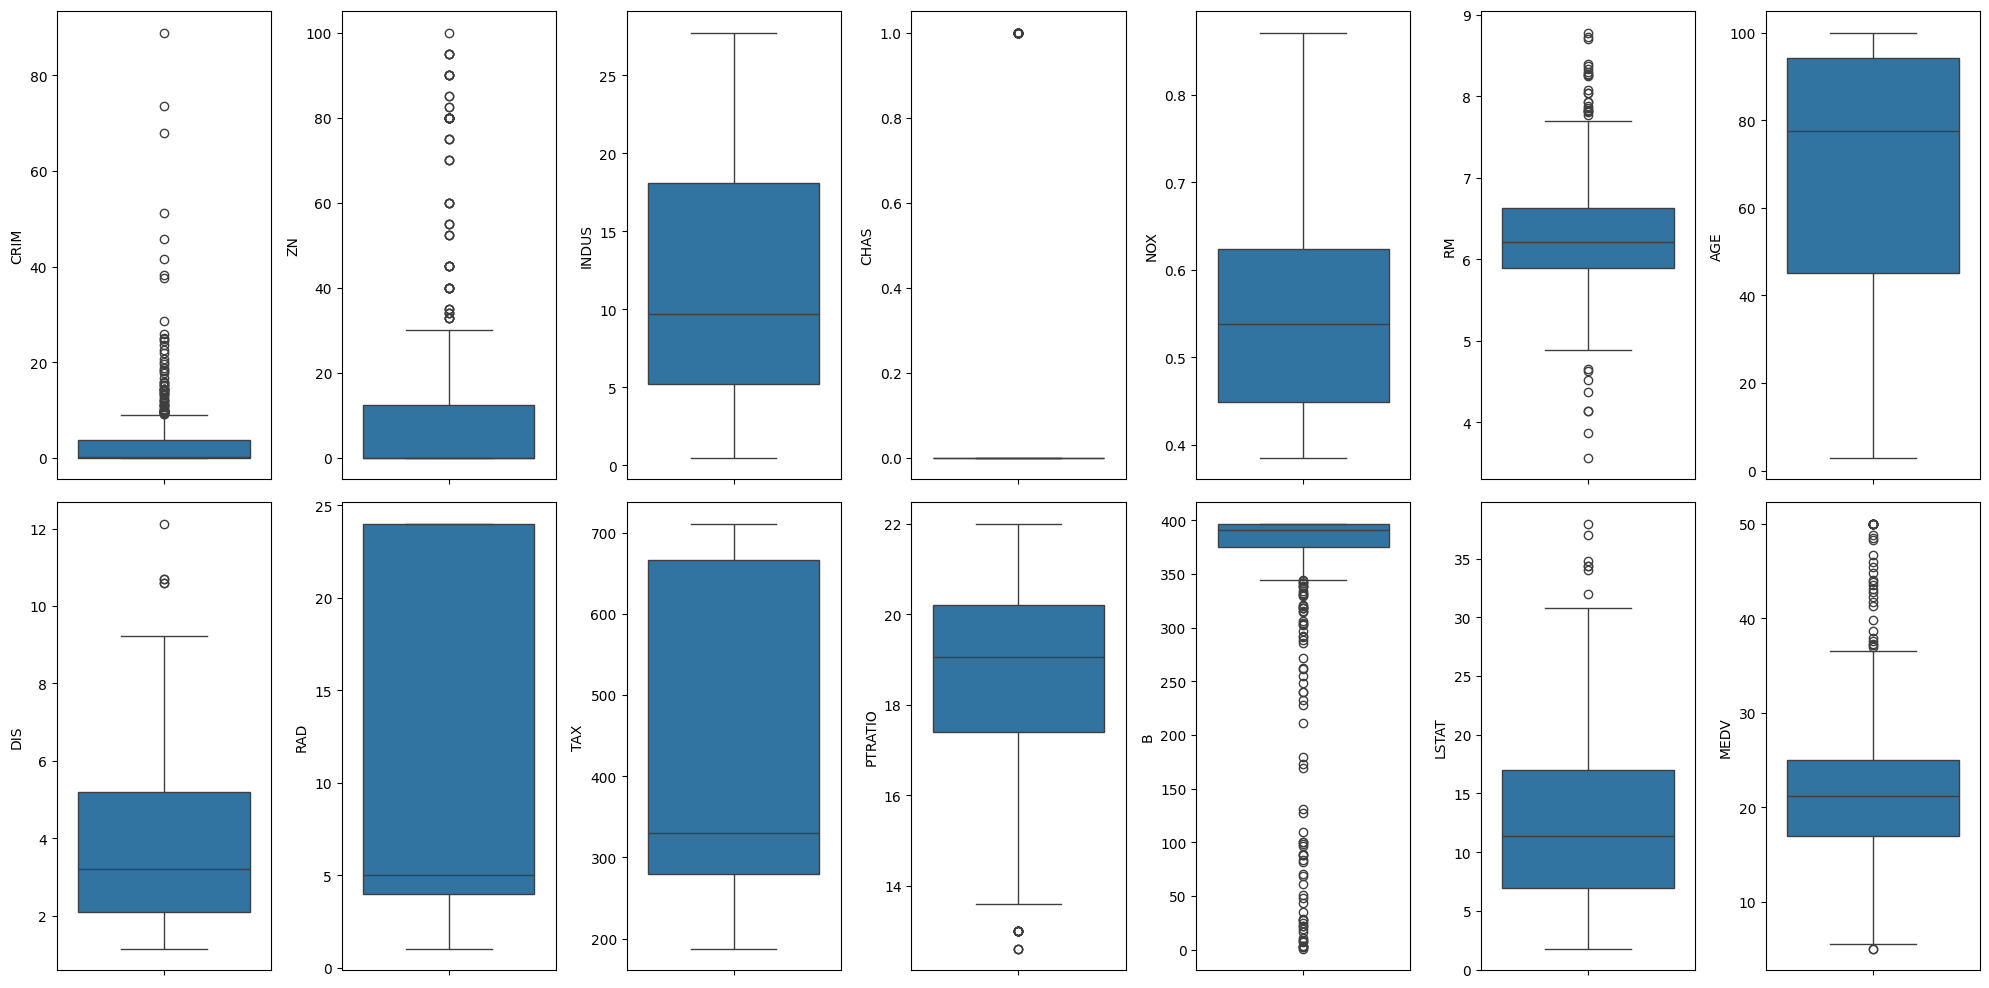

In [5]:
#Box Plot of every column in the data
fig, ax = plt.subplots(ncols = 7, nrows = 2, figsize = (20,10))
ax=ax.flatten()
index = 0
for i,j in df.items():
    sns.boxplot(y=i, data = df, ax=ax[index])
    index+=1
plt.tight_layout()

In [6]:
# Outliers count, percentage of outliers in each column
for i,j in df.items():
    q1 = j.quantile(0.25) # Lower quartile range
    q3 = j.quantile(0.75) # Upper quartile range
    iqr = q3-q1 # Interquartile range (IQR)
    # Outlier is defined as anything 1.5x the IQR from the lower or upper quartile range
    outliers = j[(j<=q1-1.5*iqr) | (j>=q3+1.5*iqr)] 
    p = np.shape(outliers)[0] * 100/np.shape(df)[0]
    print(i,p)

CRIM 13.043478260869565
ZN 13.438735177865613
INDUS 0.0
CHAS 100.0
NOX 0.0
RM 5.928853754940712
AGE 0.0
DIS 0.9881422924901185
RAD 0.0
TAX 0.0
PTRATIO 2.964426877470356
B 15.217391304347826
LSTAT 1.383399209486166
MEDV 7.905138339920948


#### Conclusions:

##### - When deciding what to do with outliers we need to look at our ML model. Gradient Boosted Regression Trees use thresholding on input features for decisions. This makes them less sensitive to high leverage points and outliers within the input features. 
##### - However for the output feature, we're planning to use Mean Square Error to train the model. This will build on each previous tree's residuals, and since outliers have much larger residuals, this will disproportionately focus the model on these points. For this reason we need to get rid of the outliers on our target feature MEDV.
##### - Any other info on columns we discluded because of outliers. Is this a good part to bring up B and it's ethical issues? Or should that go under the data description? 

#### Outlier Removal:

In [7]:
def outlier_removal(df, column: str):
    """Removes rows with outliers in a particular column

    Args:
        df (pandas DataFrame): The DataFrame we want the values removed from
        column (str): The column we're checking for outliers

    Returns:
        df (pandas DataFrame): The DataFrame minus the outliers
    """
    # Calculate IQR
    upper_QR = df[column].quantile(0.75)
    lower_QR = df[column].quantile(0.25)
    inter_QR = upper_QR-lower_QR
    # Filter for outliers
    df = df[df[column]<(upper_QR+(1.5*inter_QR))] # Gets all values below upper outlier limits
    df = df[df[column]>(lower_QR-(1.5*inter_QR))] # Gets all values above lower limits
    # Reset indexes 
    df.reset_index(drop=True)
    
    return df


In [8]:
# Remove Outliers
df = outlier_removal(df, "MEDV")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 466 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     466 non-null    float64
 1   ZN       466 non-null    float64
 2   INDUS    466 non-null    float64
 3   CHAS     466 non-null    int64  
 4   NOX      466 non-null    float64
 5   RM       466 non-null    float64
 6   AGE      466 non-null    float64
 7   DIS      466 non-null    float64
 8   RAD      466 non-null    int64  
 9   TAX      466 non-null    float64
 10  PTRATIO  466 non-null    float64
 11  B        466 non-null    float64
 12  LSTAT    466 non-null    float64
 13  MEDV     466 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 54.6 KB
None


# Task 1: Gradient Boosted Tree Regression with sklearn 

#### The code below will take you through our implementation with sklearn.  

In [21]:
# Split Data into our inputs (X) and output (y) with only our selected features
X = df[['LSTAT', 'RM', 'TAX', 'PTRATIO', 'CRIM', 'NOX']]
y = df['MEDV']

# Split data further into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=12)

# Create our model
model = GradientBoostingRegressor()
# Implement GridSearchCV to optimize hyper-parameters
params = {'min_samples_leaf':[5,10,15,20,25,30], 'max_depth':[2,3,4,5,6,7,8,9,10]} # Params for it to cycle through
clf = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring= 'r2')
# Fit model 
clf.fit(X_train, y_train)
# Make predictions
y_pred = clf.predict(X_test)
# Print model performance metrics
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))
print(clf.best_params_)


MSE: 5.7146077378878815
MAE: 1.9002305070821948
R2: 0.8780490966447156
{'max_depth': 3, 'min_samples_leaf': 15}


# Task 2: Manually Implementing Gradient Boosted Tree Regression

### Custom Functions

In [10]:
# Below are our version of the performance metric functions, and the train, test, split function

def my_train_test_split(*arrays, test_size = 0.2, training_size = 0.8, random_state = None):
    if test_size+training_size!=1:
        raise 'Bad training/test split size'
    for i in arrays:
        if len(i)!=len(arrays[0]):
            raise 'Bad input object size'
    random.seed(random_state)
    array_size = len(arrays[0])
    num_test = math.floor(array_size*test_size)
    num_train = math.floor(array_size*training_size)
    num_train+=(array_size-num_train-num_test)
    return_list = []
    test_list = random.sample(range(array_size),num_test, )
    for i in arrays:
        if type(i)==pd.DataFrame:
            test_array = pd.DataFrame(columns = X.columns)
            train_array = pd.DataFrame(columns = X.columns)
        elif type(i)==pd.Series:
            test_array = pd.Series()
            train_array = pd.Series()
        test_array = i.iloc[test_list]
        train_array = i.drop(test_list)
        return_list.append(train_array)
        return_list.append(test_array)
    return return_list
    
def my_mse(a, b):
    a = a.to_numpy()
    sum = 0
    for i in range(len(a)):
        sum+=(a[i]-b[i])**2
    sum/=len(a)
    return sum

def my_rmse(a, b):
    return math.sqrt(my_mse(a,b))

def my_mae(a,b):
    a = a.to_numpy()
    sum = 0
    for i in range(len(a)):
        sum+=abs(a[i]-b[i])
    sum/=len(a)
    return sum

def my_r2(a,b):
    a = a.to_numpy()
    y_bar = sum(a)/len(a)
    ss_res = 0
    ss_tot = 0
    for i in range(len(a)):
        ss_res+=(a[i]-b[i])**2
    for j in range(len(a)):
        ss_tot+=(a[j]-y_bar)**2
    return 1-(ss_res/ss_tot)

### Custom Classes

In [11]:
# Decision Tree Class

# Used as a week learned within the gradient boosting ensemble (builds iteratively which is why there is a max depth of 1)
# High bias but low variance, 
# Ideal for boosting methods that aim to iteratively reduce error by focusing on hard-to-predict instances.
class DecisionTree:
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
        self.tree = None

    # Each node is a decision point for traversing through the decision tree
    # Follows decision tree logic
    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
            # feature_Index and threshold are determining factors for where the split happens
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    # Recursive binary splitting
    def _build_tree(self, X, y, depth):
        # Continues to split until the maximum specified depth is reached
        num_samples, num_features = X.shape
        # Stopping condition: if the current depth exceeds the max depth or the dataset cannot be split further
        if depth >= self.max_depth or num_samples <= 1:
            leaf_value = self._calculate_leaf_value(y)
            # Create a leaf node with the calculated value
            return self.Node(value=leaf_value)

        # Finds the best features by iterating through and selecting lowest MSE
        best_feature, best_threshold = self._find_best_split(X, y, num_samples, num_features)
        if best_feature is None:
            # If no split can improve the outcome, create a leaf node
            return self.Node(value=self._calculate_leaf_value(y))
        
        # Split the dataset and recursively build left and right subtrees
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left_subtree = self._build_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right_subtree = self._build_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return self.Node(feature_index=best_feature, threshold=best_threshold, left=left_subtree, right=right_subtree)

    def _calculate_leaf_value(self, y):
        # The leaf value can be the mean of the target values, calculates that mean value for the leaf node
        return np.mean(y)

    def _find_best_split(self, X, y, num_samples, num_features):
        # Finds the best feature and threshold to split on based on the lowest MSE
        best_feature, best_threshold = None, None
        best_mse = np.inf
        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            # Splits the dataset and calculates the MSE for this split
            for threshold in thresholds:
                left_idxs, right_idxs = self._split(X[:, feature_index], threshold)
                if len(left_idxs) == 0 or len(right_idxs) == 0:
                    continue
                mse = self._calculate_mse(y[left_idxs], y[right_idxs])
                # Update split if current mse is better
                if mse < best_mse:
                    best_mse = mse
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    # Splits dataset into left/right based on threshold of given feature
    def _split(self, feature_values, threshold):
        left_idxs = np.where(feature_values <= threshold)[0]
        right_idxs = np.where(feature_values > threshold)[0]
        return left_idxs, right_idxs

    def _calculate_mse(self, left_y, right_y):
        # Calculate the MSE of the left and right splits by weighted averages of variance
        total_left_mse = np.var(left_y) * len(left_y) if len(left_y) > 0 else 0
        total_right_mse = np.var(right_y) * len(right_y) if len(right_y) > 0 else 0
        total_mse = (total_left_mse + total_right_mse) / (len(left_y) + len(right_y))
        return total_mse
    
    def predict(self, X):
        # Predictions array to store predictions for each sample in X
        predictions = np.array([self._traverse_tree(x, self.tree) for x in X])
        return predictions

    def _traverse_tree(self, x, node):
        # Recursive method to traverse the tree for a single sample 'x' until a leaf node is reached
        if node.value is not None:
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

In [12]:
# Gradient Boost Class

class GradientBoostAll:
    def __init__(self, n_estimators: int = 25, max_depth: int = 1, learning_rate: int =.1):
        self.max_depth = max_depth # Max depth of the trees
        self.n_estimators = n_estimators # Number of trees
        self.learning_rate = learning_rate # Learning rate, step size for parameter update
        self.trees = [] # List of our trees
    
    def fit(self, X_train, y_train):
        # To start all residuals = y_train
        residuals = np.copy(y_train)
        self.f_hat = 0 
        # Now time to make decision trees
        for i in range(self.n_estimators):
            # Build and Fit Tree to data
            tree = DecisionTree(max_depth=self.max_depth)
            tree.fit(X_train, residuals)
            # Save our tree
            self.trees.append(tree)
            # Make prediction
            f_hat_b = tree.predict(X_train)
            # Update f_hat
            self.f_hat += (self.learning_rate*f_hat_b) 
            # Update residuals
            residuals = residuals - (self.learning_rate*f_hat_b)
        return self
    
    def predict(self, X_test):
        y_hat = np.zeros((X_test.shape[0], ))
        for tree in self.trees:
            y_hat += self.learning_rate*tree.predict(X_test)
        return y_hat

### Testing the Implementation

In [28]:
# Split the dataset using our function
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X_train, X_test, y_train, y_test = my_train_test_split(X,y,test_size=0.2, random_state=12)

# Turn to np for now
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

# Gradient Boost Regression 
our_model = GradientBoostAll(n_estimators= 100, max_depth=5)
# Fit the model
our_model.fit(X_train_np, y_train_np)
# Make the predictions
predictions = our_model.predict(X_test_np)
# Prints Model Metrics
print("MSE:", my_mse(y_test, predictions))
print("MAE:", my_mae(y_test, predictions))
print("R2:", my_r2(y_test, predictions))

MSE: 6.21420632196426
MAE: 1.8137568628094058
R2: 0.8516335386981123
